# Lab 6 - Operational Fairness in DA/ML
Week 6 - Q3, 22/23 <br>
SEN163B: Responsible Data Analytics<br>
 

By <b> Nadia Metoui* </b> <br>
TA <b> Darsh Modi</b> <br> 
Faculty of Technology, Policy, and Management (TPM)<br>

***Learning Objectives***<br>
At the end of this lab, you will be able to 

- Use data analytics tools to measure disaparities in a Data Analytics Project
- Use data analytics tools to mitigate disaparities in a Data Analytics Project


***Structure***
- Part I. Measuring Disparities with Aequitas
- Part II Mitigating Bias/Disparities with FAI360 (will be provided in a separate notebook for the second part of the Lab)
- Part III: Mitigating Bias/Disparities with FairLearn (a tutorial will be provided for homework exploration)


##Part I: Measuring Disparities with Aequitas*



In this first part of the lab, we will explore [**Aequitas**](http://www.datasciencepublicpolicy.org/our-work/tools-guides/aequitas/), Bias and fairness auditing toolkit with a python library implementation. Aequitas does NOT have any mitigation tools. It only detects bias, defined as disaparities in data. It gives very good visualizations you can use to highlight the importance of disaparities to your data team.


We will also explore **Intersectionality**, and reflect on its effects.

Then, we will explore **The Fairness Tree**, a flow chart created by the [Data Science and Public Policy Lab at CMU](http://www.datasciencepublicpolicy.org/) to help find the fairness measures relevant to your own responsible data analytics project, when you do don't forget to think about different stakeholders.

---
Acknowledgement: this Part of  lab is inspired from the offical Aequitas tutorial. You can find the tutorial [*HERE*](https://dssg.github.io/aequitas/examples/compas_demo.html). Take a look and use some of the code to help you.

The Official publication on the Aequitas toolkit can be found [*HERE*](https://arxiv.org/pdf/1811.05577.pdf). It is also on Brightspace. Read it! it is very relevant to your project.

Analysis Steps
- Step 0: Understanding the Use Case (COMPAS)
- Step 1: Set-up 
- Step 2: Explore and familiarize with the data
- Step 3: Explore Aequitas Toolkit

###Step 0: Understanding the Use Case (COMPAS)

In 2016, ProPublica reported on racial inequality in automated criminal risk assessment algorithms. The [report](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) is based on [this analysis](https://github.com/propublica/compas-analysis). Using a clean version of the COMPAS dataset from the ProPublica GitHub repo, we demostrate the use of the Aequitas bias reporting tool.

Northpointe's COMPAS (Correctional Offender Management Profiling for Alternative Sanctions) is one of the most widesly utilized risk assessment tools/ algorithms within the criminal justice system for guiding decisions such as how to set bail. The ProPublica dataset represents two years of COMPAS predicitons from Broward County, FL.

COMPAS produces a risk score that predicts a person's likelihood of commiting a crime in the next two years. The output is a score between 1 and 10 that maps to low, medium or high. For Aequitas, we collapse this to a binary prediction. A score of 0 indicates a prediction of "low" risk according to COMPAS, while a 1 indicates "high" or "medium" risk.

This categorization is based on ProPublica's interpretation of Northpointe's practioner guide:

    "According to Northpointe’s practitioners guide, COMPAS “scores in the medium and high range 
    garner more interest from supervision agencies than low scores, as a low score would suggest 
    there is little risk of general recidivism,” so we considered scores any higher than “low” to 
    indicate a risk of recidivism."

###Step 1: Set-up

You will first install the library *aequitas* 

<div class="alert alert-block alert-danger">
<b>Note:</b> Uncomment and run the next cell if you have not previously installed aequitas.
</div>

In [1]:
!pip install aequitas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<div class="alert alert-block alert-danger">
<b>Note:</b> Only uncomment and run if you have Attributeerror: module ‘pil.image’ has no attribute ‘resampling’!
</div>

In [2]:
# in case you have Attributeerror: module ‘pil.image’ has no attribute ‘resampling’!
!pip install Pillow==9.1.0 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Then you will load  the required libraries for this part (usually no installation is needed).  The main libraries we will use in Part I are `pandas`, `seaborn` and `aequitas`. 

In [3]:
import pandas as pd
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap

# import warnings; warnings.simplefilter('ignore')

%matplotlib inline

###Step 2: Explore and familiarize with the data

**Load and undestaind the data**

In [4]:
df = pd.read_csv("https://github.com/dssg/aequitas/raw/master/examples/data/compas_for_aequitas.csv")


The data provided for this Part of the Lab is not the "full" training data used for COMPAS. It is a dataset composed of: sensitive attributes used to train COMPAS `race`,	`sex`,	`age_cat`, The original labels used to train COMPAS, and the output score or predictions of COMPAS.

COMPAS uses a logistic regression-based model to predict a recidivism score. We will not concern ourselves with training the model in this part. We will only use the output data after training and testing


For your project, you will build such a table before using Aequitas. To do so you will use only your test data. You select the sensitive attributes and their proxies the ground-truth labels and the predictions made by your model
Aequitas is picky about the names of columns given to it. You have to provide the following columns:
1. `score` is the prediction made by your model
1. `label_value` is the ground-truth label
1. The only other columns you should keep are sensitive attribute (and proxy) labels

**Note:** remember Aequitas only uses binary scores so if you are using regressions you have to collapse predictions to a binary setting. Here a score of 0 indicates a prediction of a "low" risk of recidivism 1 indicates a "high" or "medium" risk.

In [5]:
df.head()

,entity_id,score,label_value,race,sex,age_cat
0,1,0.0,0,Other,Male,Greater than 45
1,3,0.0,1,African-American,Male,25 - 45
2,4,0.0,1,African-American,Male,Less than 25
3,5,1.0,0,African-American,Male,Less than 25
4,6,0.0,0,Other,Male,25 - 45


In [6]:
df.sample(15)

,entity_id,score,label_value,race,sex,age_cat
970,1488,0.0,1,African-American,Male,25 - 45
4923,7496,1.0,0,Caucasian,Male,Less than 25
1875,2851,1.0,0,Other,Male,25 - 45
4490,6857,0.0,0,African-American,Female,25 - 45
4393,6698,1.0,1,African-American,Male,25 - 45
2494,3797,1.0,0,African-American,Male,25 - 45
663,1008,0.0,0,Caucasian,Male,Greater than 45
2503,3811,0.0,1,African-American,Male,Greater than 45
3203,4906,1.0,1,African-American,Male,Less than 25
3534,5403,1.0,1,African-American,Male,25 - 45


In [7]:
df.shape

(7214, 6)

**Explore the data**
 

##### **Q1**: Explore and understaind the data

Produce as many visualisation and table exploration as you wish. The goal is to get a sence of the data destributions. E.g., 
- What are the attributs and featuers?
- What is the score destribution by attribute (race, sex or age) etc...

**Tip**: You can use `sns.countplot()`

***Distributions in the dataset (before training)***

In [8]:
lable_palette = sns.diverging_palette(225, 35, n=2)

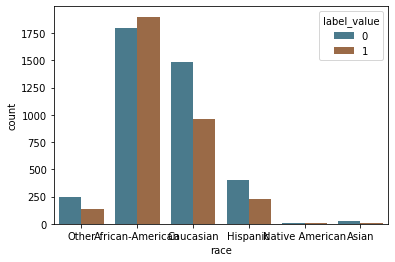

In [9]:
by_race = sns.countplot(x="race", hue="label_value", data=df, palette=lable_palette)

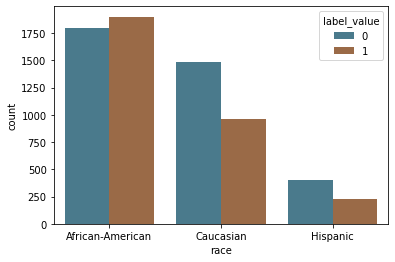

In [10]:
by_race = sns.countplot(x="race", hue="label_value", data=df[df.race.isin(['African-American', 'Caucasian', 'Hispanic'])], palette=lable_palette)

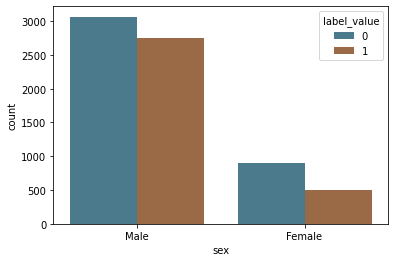

In [11]:
by_sex = sns.countplot(x="sex", hue="label_value", data=df, palette=lable_palette)

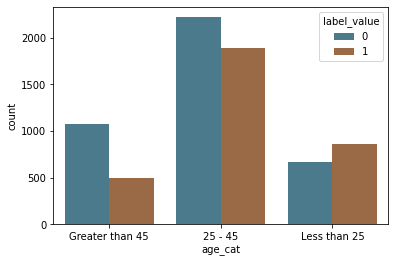

In [12]:
by_age = sns.countplot(x="age_cat", hue="label_value", data=df, palette=lable_palette)

***Distributions in model outcomes***

In [13]:
outcome_palette = sns.color_palette("Set1", 2)

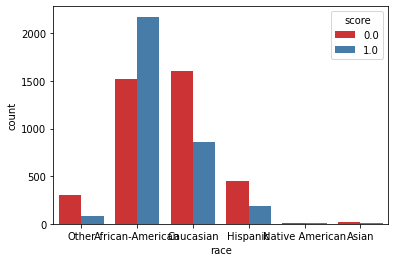

In [14]:
by_race = sns.countplot(x="race", hue="score", data=df, palette=outcome_palette)

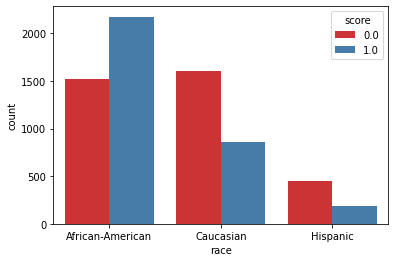

In [15]:
by_race = sns.countplot(x="race", hue="score", data=df[df.race.isin(['African-American', 'Caucasian', 'Hispanic'])], palette=outcome_palette)

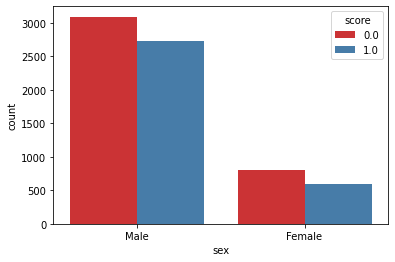

In [16]:
by_sex = sns.countplot(x="sex", hue="score", data=df, palette=outcome_palette)

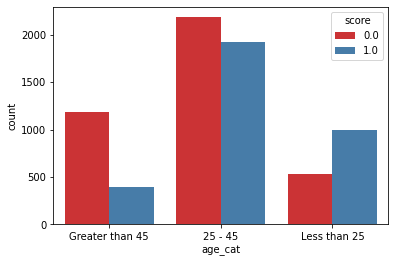

In [17]:
by_age = sns.countplot(x="age_cat", hue="score", data=df, palette=outcome_palette)

In [18]:
# add your code here and add any number of cells you need

##### **Q2**:Could you identify any disparities in these destributions


***Distributions in the dataset (before training)***

This dataset includes information about whether or not the subject recidivated, and so we can directly test the accuracy of the predictions. First, we visualize the recidivsm rates across race. 

Following ProPublica, we defined recidivism as a new arrest within two years. (If a person recidivates, `label_value` = `1`). They "based this decision on Northpointe’s practitioners guide, which says that its recidivism score is meant to predict 'a new misdemeanor or felony offense within two years of the COMPAS administration date.'"

In Lab 4, Week 4, of this course we learned several approaches to check disparities and skew in data. See lab 4 to further interpret these distributions disparities. 

***Distributions in model outcomes***

In the bar charts *Distributions in model outcomes*, we can observe a large difference in outcomes distributed by `race`, with a majority of white and Hispanic people predicted as low risk (score = `0`) and a majority of black people predicted high and medium risk (score = `1`). 

We can also observe distribution disparities based on age category `age_cat`: the majority of individuals in categories over 25 (`25 - 45` and `Greater than 45`) are predicted as low risk (score = `0`), the majority of individuals  below 25 (`Less than 25`) are predicted as high and medium risk (score = `1`).

###Step 3: Explore Aequitas Toolkit

At this point if your exploration you should have identified patternes of disparities or destribution skew in COMPAS output predictions

As a data scientist you face the challenge of determining whether or not such patterns reflect bias/unfairness or not. The fact that there are multiple ways to measure bias adds complexity to the decision-making process. With Aequitas, You can build a report of various fairness metrics to aid in this process.

Applying Aequitas progammatically is a three step process represented by three python classes: 

`Group()`: Define groups 

`Bias()`: Calculate disparities

`Fairness()`: Assert fairness

Each class builds on the previous one expanding the output DataFrame.

#### Preprocessing and Data Formatting

as mentioned above Aequitas The Aequitas tool always requires a binary **`score`** column and a binary **`label_value`** these will be used to generate metrics such as False Discovery Rate, False Positive Rate, False Omission Rate, and False Negative Rate).

Preprocessing includes but is not limited to checking for mandatory `score` and `label_value` columns as well as at least one column representing sensitive attributes specific to the dataset. See [documentation](https://dssg.github.io/aequitas/api/aequitas.html) for more information about input data.

**Note** `entity_id` is not necessary for this example, Aequitas recognizes `entity_id` as a reserve column name and will not recognize it as an attribute column.

#### Calculate Group Specific Metrics

_Aequitas Group() Class_

Aequitas's `Group()` class enables researchers to evaluate biases across all subgroups in their dataset by assembling a confusion matrix of each subgroup, calculating commonly used metrics such as false positive rate and false omission rate, as well as counts by group and group prevelance among the sample population. 

The **`get_crosstabs()`** method tabulates a confusion matrix for each subgroup and calculates commonly used metrics such as false positive rate and false omission rate. It also provides counts by group and group prevelances.

***Group Counts Calculated:***

| Count Type | Column Name |
| --- | --- |
| False Positive Count | 'fp' |
| False Negative Count | 'fn' |
| True Negative Count | 'tn' |
| True Positive Count | 'tp' |
| Predicted Positive Count | 'pp' |
| Predicted Negative Count | 'pn' |
| Count of Negative Labels in Group | 'group_label_neg' |
| Count of Positive Labels in Group | 'group_label_pos' | 
| Group Size | 'group_size'|
| Total Entities | 'total_entities' |

***Absolute Metrics Calculated:***

| Metric | Column Name |
| --- | --- |
| True Positive Rate | 'tpr' |
| True Negative Rate | 'tnr' |
| False Omission Rate | 'for' |
| False Discovery Rate | 'fdr' |
| False Positive Rate | 'fpr' |
| False Negative Rate | 'fnr' |
| Negative Predictive Value | 'npv' |
| Precision | 'precision' |
| Predicted Positive Ratio$_k$ | 'ppr' |
| Predicted Positive Ratio$_g$ | 'pprev' |
| Group Prevalence | 'prev' |


##### **Q3:** Cross Tabs

Use `get_crosstabs()` method expects a dataframe with predefined columns `score`, and `label_value` and treats other columns (with a few exceptions) as attributes against which to test for disparities. In this case, we include `race`, `sex` and `age_cat`.

**Note**: The **`get_crosstabs()`** method expects a dataframe with predefined columns `score`, and `label_value` and treats other columns (with a few exceptions) as attributes against which to test for disparities. In this case, we include `race`, `sex` and `age_cat`. 

In [19]:
group = Group()
xtab, _ = group.get_crosstabs(df)

##### **Q4:** What are bias metrics across groups?

Once you have run the `Group()` class **`get_crosstabs()`** method, you'll have a dataframe of the [group counts](#counts_description) and [group value bias metrics](#counts_description).

The `Group()` class has a **`list_absolute_metrics()`** method, which you can use for faster slicing to view just  counts or bias metrics.



In [20]:
absolute_metrics = group.list_absolute_metrics(xtab)

A. Display counts across sample population groups


In [21]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,3317,race,African-American,2174,1522,805,532,990,1369,1901,1795,3696,7214
1,0,binary 0/1,3317,race,Asian,8,24,2,3,21,6,9,23,32,7214
2,0,binary 0/1,3317,race,Caucasian,854,1600,349,461,1139,505,966,1488,2454,7214
3,0,binary 0/1,3317,race,Hispanic,190,447,87,129,318,103,232,405,637,7214
4,0,binary 0/1,3317,race,Native American,12,6,3,1,5,9,10,8,18,7214
5,0,binary 0/1,3317,race,Other,79,298,36,90,208,43,133,244,377,7214
6,0,binary 0/1,3317,sex,Female,591,804,288,195,609,303,498,897,1395,7214
7,0,binary 0/1,3317,sex,Male,2726,3093,994,1021,2072,1732,2753,3066,5819,7214
8,0,binary 0/1,3317,age_cat,25 - 45,1924,2185,741,706,1479,1183,1889,2220,4109,7214
9,0,binary 0/1,3317,age_cat,Greater than 45,394,1182,181,285,897,213,498,1078,1576,7214


B. calculated absolute metrics for each sample population group


In [22]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race,African-American,0.72,0.55,0.35,0.37,0.45,0.28,0.65,0.63,0.66,0.59,0.51
1,race,Asian,0.67,0.91,0.12,0.25,0.09,0.33,0.88,0.75,0.00,0.25,0.28
2,race,Caucasian,0.52,0.77,0.29,0.41,0.23,0.48,0.71,0.59,0.26,0.35,0.39
3,race,Hispanic,0.44,0.79,0.29,0.46,0.21,0.56,0.71,0.54,0.06,0.30,0.36
4,race,Native American,0.90,0.62,0.17,0.25,0.38,0.10,0.83,0.75,0.00,0.67,0.56
5,race,Other,0.32,0.85,0.30,0.46,0.15,0.68,0.70,0.54,0.02,0.21,0.35
6,sex,Female,0.61,0.68,0.24,0.49,0.32,0.39,0.76,0.51,0.18,0.42,0.36
7,sex,Male,0.63,0.68,0.33,0.36,0.32,0.37,0.67,0.64,0.82,0.47,0.47
8,age_cat,25 - 45,0.63,0.67,0.32,0.39,0.33,0.37,0.68,0.61,0.58,0.47,0.46
9,age_cat,Greater than 45,0.43,0.83,0.24,0.46,0.17,0.57,0.76,0.54,0.12,0.25,0.32


C. Comment the results

**How to read/interpret the crosstabs**

In the slice of the crosstab dataframe created by the `Group()` class **`get_crosstabs()`** method directly above, we see that African-Americans have a false positive rate (`fpr`) of 45%, while Caucasians have a false positive rate of only 23%. This means that African-American people are far more likely to be falsely labeled as high-risk than white people. On the other hand, false ommision rates (`for`) and false discovery rates (`fdr`) are much closer for those two groups.


#### Explore levels of disparity exist between population groups

_Aequitas Bias() Class_

We use the Aequitas `Bias()` class to calculate disparities between groups based on the crosstab returned by the `Group()` class **`get_crosstabs()`** method described above. Disparities are calculated as a ratio of a metric for a group of interest compared to a base group. For example, the False Negative Rate Disparity for black defendants vis-a-vis whites is:
$$Disparity_{FNR} =  \frac{FNR_{black}}{FNR_{white}}$$ 

Below, we use **`get_disparity_predefined_groups()`** which allows us to choose reference groups that clarify the output for the practitioner. 

The Aequitas `Bias()` class includes two additional get disparity functions: **`get_disparity_major_group()`** and **`get_disparity_min_metric()`**, which automate base group selection based on sample majority (across each attribute) and minimum value for each calculated bias metric, respectively.  

The **`get_disparity_predefined_groups()`** allows user to define a base group for each attribute, as illustrated below. 

***Disparities Calcuated:***

| Metric | Column Name |
| --- | --- |
| True Positive Rate Disparity | 'tpr_disprity' |
| True Negative Rate | 'tnr_disparity' |
| False Omission Rate | 'for_disparity' |
| False Discovery Rate | 'fdr_disparity' |
| False Positive Rate | 'fpr_disparity' |
| False NegativeRate | 'fnr_disparity' |
| Negative Predictive Value | 'npv_disparity' |
| Precision Disparity | 'precision_disparity' |
| Predicted Positive Ratio$_k$ Disparity | 'ppr_disparity' |
| Predicted Positive Ratio$_g$ Disparity | 'pprev_disparity' |


Columns for each disparity are appended to the crosstab dataframe, along with a column indicating the reference group for each calculated metric (denoted by `[METRIC NAME]_ref_group_value`). We see a slice of the dataframe with calculated metrics in the next section.

In [23]:
bias = Bias()

##### **Q5**: write the code to calculate disparities in relation to a user-specified group for each attribute 

The `Bias()` class has three methods to calculate disparities  `get_disparity_major_group`, `get_disparity_min_group` and `get_disparity_predefined_groups`. See the package [`src.aequitas.bias`](https://dssg.github.io/aequitas/api/aequitas.html#module-src.aequitas.bias) for a review of the differences between these methods.


In this lab you can use `get_disparity_predefined_groups`

In [24]:
bias_df = bias.get_disparity_predefined_groups(xtab, original_df=df, 
                                        ref_groups_dict={'race':'Caucasian', 'sex':'Male', 'age_cat':'25 - 45'}, 
                                        alpha=0.05, check_significance=True, 
                                        mask_significance=True)
bias_df.style

get_disparity_predefined_group()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,label_value_significance,score_significance,fdr_disparity,fdr_ref_group_value,fdr_significance,fnr_disparity,fnr_ref_group_value,fnr_significance,for_disparity,for_ref_group_value,for_significance,fpr_disparity,fpr_ref_group_value,fpr_significance,npv_disparity,npv_ref_group_value,npv_significance,ppr_disparity,ppr_ref_group_value,ppr_significance,pprev_disparity,pprev_ref_group_value,pprev_significance,precision_disparity,precision_ref_group_value,precision_significance,tnr_disparity,tnr_ref_group_value,tnr_significance,tpr_disparity,tpr_ref_group_value,tpr_significance
0,0,binary 0/1,3317,race,African-American,0.720147,0.551532,0.349540,0.370285,0.448468,0.279853,0.650460,0.629715,2174,1522,0.655412,0.588203,805,532,990,1369,1901,1795,3696,7214,0.514340,True,True,0.906085,Caucasian,False,0.586416,Caucasian,True,1.213154,Caucasian,True,1.912093,Caucasian,False,0.913728,Caucasian,True,2.545667,Caucasian,True,1.690224,Caucasian,True,1.064904,Caucasian,False,0.720526,Caucasian,False,1.377549,Caucasian,True
1,0,binary 0/1,3317,race,Asian,0.666667,0.913043,0.125000,0.250000,0.086957,0.333333,0.875000,0.750000,8,24,0.002412,0.250000,2,3,21,6,9,23,32,7214,0.281250,False,False,0.611748,Caucasian,False,0.698482,Caucasian,False,0.433839,Caucasian,False,0.370749,Caucasian,False,1.229148,Caucasian,False,0.009368,Caucasian,False,0.718384,Caucasian,False,1.268317,Caucasian,False,1.192808,Caucasian,False,1.275248,Caucasian,False
2,0,binary 0/1,3317,race,Caucasian,0.522774,0.765457,0.288125,0.408665,0.234543,0.477226,0.711875,0.591335,854,1600,0.257462,0.348003,349,461,1139,505,966,1488,2454,7214,0.393643,False,False,1.000000,Caucasian,False,1.000000,Caucasian,False,1.000000,Caucasian,False,1.000000,Caucasian,False,1.000000,Caucasian,False,1.000000,Caucasian,False,1.000000,Caucasian,False,1.000000,Caucasian,False,1.000000,Caucasian,False,1.000000,Caucasian,False
3,0,binary 0/1,3317,race,Hispanic,0.443966,0.785185,0.288591,0.457895,0.214815,0.556034,0.711409,0.542105,190,447,0.057281,0.298273,87,129,318,103,232,405,637,7214,0.364207,False,True,1.120464,Caucasian,False,1.165140,Caucasian,False,1.001616,Caucasian,False,0.915887,Caucasian,False,0.999346,Caucasian,False,0.222482,Caucasian,True,0.857099,Caucasian,True,0.916748,Caucasian,False,1.025773,Caucasian,False,0.849249,Caucasian,False
4,0,binary 0/1,3317,race,Native American,0.900000,0.625000,0.166667,0.250000,0.375000,0.100000,0.833333,0.750000,12,6,0.003618,0.666667,3,1,5,9,10,8,18,7214,0.555556,False,True,0.611748,Caucasian,False,0.209544,Caucasian,False,0.578453,Caucasian,False,1.598854,Caucasian,False,1.170618,Caucasian,False,0.014052,Caucasian,True,1.915691,Caucasian,True,1.268317,Caucasian,False,0.816506,Caucasian,False,1.721584,Caucasian,False
5,0,binary 0/1,3317,race,Other,0.323308,0.852459,0.302013,0.455696,0.147541,0.676692,0.697987,0.544304,79,298,0.023817,0.209549,36,90,208,43,133,244,377,7214,0.352785,False,True,1.115085,Caucasian,False,1.417970,Caucasian,False,1.048203,Caucasian,False,0.629057,Caucasian,False,0.980490,Caucasian,False,0.092506,Caucasian,True,0.602147,Caucasian,True,0.920466,Caucasian,False,1.113660,Caucasian,False,0.618447,Caucasian,False
6,0,binary 0/1,3317,sex,Female,0.608434,0.678930,0.242537,0.487310,0.321070,0.391566,0.757463,0.512690,591,804,0.178173,0.423656,288,195,609,303,498,897,1395,7214,0.356989,True,True,1.336425,Male,True,1.055810,Male,True,0.734738,Male,True,0.990343,Male,True,1.130710,Male,True,0.216801,Male,True,0.904348,Male,True,0.806925,Male,True,1.004633,Male,True,0.967101,Male,True
7,0,binary 0/1,3317,sex,Male,0.629132,0.675799,0.330100,0.364637,0.324201,0.370868,0.669900,0.635363,2726,3093,0.821827,0.468465,994,1021,2072,1732,2753,3066,5819,7214,0.473105,False,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000,Male,False,1.000000

##### **Q6**: Add disparity metrics to the dataframe

The `Bias()` class has three methods to display disparity calculation:  
- `list_absolute_metrics`
- `list_disparities` 
- `list_significance`

See the package [`src.aequitas.bias`](https://dssg.github.io/aequitas/api/aequitas.html#module-src.aequitas.bias) for a review of the differences between these methods.

In [25]:
# View disparity metrics added to dataframe
bias_df[['attribute_name', 'attribute_value'] +
     bias.list_disparities(bias_df) + bias.list_significance(bias_df)].style

,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,tnr_disparity,tpr_disparity,label_value_significance,score_significance,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,race,African-American,0.906085,0.586416,1.213154,1.912093,0.913728,2.545667,1.690224,1.064904,0.720526,1.377549,True,True,False,True,True,False,True,True,True,False,False,True
1,race,Asian,0.611748,0.698482,0.433839,0.370749,1.229148,0.009368,0.718384,1.268317,1.192808,1.275248,False,False,False,False,False,False,False,False,False,False,False,False
2,race,Caucasian,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,False,False,False,False,False,False,False,False,False,False,False,False
3,race,Hispanic,1.120464,1.165140,1.001616,0.915887,0.999346,0.222482,0.857099,0.916748,1.025773,0.849249,False,True,False,False,False,False,False,True,True,False,False,False
4,race,Native American,0.611748,0.209544,0.578453,1.598854,1.170618,0.014052,1.915691,1.268317,0.816506,1.721584,False,True,False,False,False,False,False,True,True,False,False,False
5,race,Other,1.115085,1.417970,1.048203,0.629057,0.980490,0.092506,0.602147,0.920466,1.113660,0.618447,False,True,False,False,False,False,False,True,True,False,False,False
6,sex,Female,1.336425,1.055810,0.734738,0.990343,1.130710,0.216801,0.904348,0.806925,1.004633,0.967101,True,True,True,True,True,True,True,True,True,True,True,True
7,sex,Male,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,False,False,False,False,False,False,False,False,False,False,False,False
8,age_cat,25 - 45,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,False,False,False,False,False,False,False,False,False,False,False,False
9,age_cat,Greater than 45,1.192804,1.531238,0.746232,0.503031,1.121136,0.204782,0.533914,0.879232,1.248989,0.682963,True,True,True,True,True,True,True,True,True,True,True,True


##### **Q7**: Aequitas Visualizations
Use `summary` to displya the over all fairness of the COMPAS model

In [26]:
metrics = ['fpr','fdr']
disparity_tolerance = 1.25

In [27]:
ap.summary(bias_df, metrics, fairness_threshold = disparity_tolerance)

alt.VConcatChart(...)

##### **Q8**:: Check for disparities in Race

Use `disparity` to display disparities by sensitive attribut  `race`, `sex` and `age_cat`

In [28]:
ap.disparity(bias_df, metrics, 'race', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

In [29]:
ap.disparity(bias_df, metrics, 'sex', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

In [30]:
ap.disparity(bias_df, metrics, 'age_cat', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

##### **Q9**: Intersectionality

A. Starting from the original dataframe (uploaded at the beginning of the lab), write code to create a new column in `data` called `race_sex` which concatenates the `race` and `sex` columns with an underscore, so it has entries like `African-American-Male` or `Hispanic_Female`, etc.


In [31]:
inter_df = pd.read_csv("https://github.com/dssg/aequitas/raw/master/examples/data/compas_for_aequitas.csv")
inter_df.head()

,entity_id,score,label_value,race,sex,age_cat
0,1,0.0,0,Other,Male,Greater than 45
1,3,0.0,1,African-American,Male,25 - 45
2,4,0.0,1,African-American,Male,Less than 25
3,5,1.0,0,African-American,Male,Less than 25
4,6,0.0,0,Other,Male,25 - 45


In [32]:
# create the column race_sex
inter_df['race_sex']=[f"{race}_{sex}" for race, sex	 in zip(inter_df.race,inter_df.sex)]
inter_df.head()

,entity_id,score,label_value,race,sex,age_cat,race_sex
0,1,0.0,0,Other,Male,Greater than 45,Other_Male
1,3,0.0,1,African-American,Male,25 - 45,African-American_Male
2,4,0.0,1,African-American,Male,Less than 25,African-American_Male
3,5,1.0,0,African-American,Male,Less than 25,African-American_Male
4,6,0.0,0,Other,Male,25 - 45,Other_Male


In [34]:
# we will drop race and sex for simplicity sake in this lab
inter_df=inter_df.drop('race', axis=1)
inter_df=inter_df.drop('sex', axis=1)

In [36]:
inter_df.sample(5)

,entity_id,score,label_value,age_cat,race_sex
4289,6541,1.0,1,Less than 25,Caucasian_Male
4168,6368,1.0,1,25 - 45,African-American_Male
2800,4280,1.0,0,25 - 45,Hispanic_Male
803,1219,0.0,0,25 - 45,African-American_Female
6421,9797,0.0,1,25 - 45,African-American_Male



B. List the new intersectional categories

In [37]:
inter_df.race_sex.unique()

array(['Other_Male', 'African-American_Male', 'Caucasian_Male',
       'Caucasian_Female', 'Hispanic_Male', 'African-American_Female',
       'Other_Female', 'Hispanic_Female', 'Native American_Female',
       'Asian_Male', 'Native American_Male', 'Asian_Female'], dtype=object)

B. 

'Other_Male', 'African-American_Male', 'Caucasian_Male',
       'Caucasian_Female', 'Hispanic_Male', 'African-American_Female',
       'Other_Female', 'Hispanic_Female', 'Native American_Female',
       'Asian_Male', 'Native American_Male', 'Asian_Female'

##### **Q10**:: Bias in Intersectionality

A. Repeat the analysis above focusing in this new intersectional categories. 

B. Write down your observations.

In [38]:
group_inter = Group()
xtab, _ = group_inter.get_crosstabs(inter_df)
absolute_metrics = group_inter.list_absolute_metrics(xtab)
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,3317,age_cat,25 - 45,1924,2185,741,706,1479,1183,1889,2220,4109,7214
1,0,binary 0/1,3317,age_cat,Greater than 45,394,1182,181,285,897,213,498,1078,1576,7214
2,0,binary 0/1,3317,age_cat,Less than 25,999,530,360,225,305,639,864,665,1529,7214
3,0,binary 0/1,3317,race_sex,African-American_Female,337,315,164,74,241,173,247,405,652,7214
4,0,binary 0/1,3317,race_sex,African-American_Male,1837,1207,641,458,749,1196,1654,1390,3044,7214
5,0,binary 0/1,3317,race_sex,Asian_Female,0,2,0,1,1,0,1,1,2,7214
6,0,binary 0/1,3317,race_sex,Asian_Male,8,22,2,2,20,6,8,22,30,7214
7,0,binary 0/1,3317,race_sex,Caucasian_Female,224,343,111,86,257,113,199,368,567,7214
8,0,binary 0/1,3317,race_sex,Caucasian_Male,630,1257,238,375,882,392,767,1120,1887,7214
9,0,binary 0/1,3317,race_sex,Hispanic_Female,16,87,7,24,63,9,33,70,103,7214


In [39]:
inter_df

,entity_id,score,label_value,age_cat,race_sex
0,1,0.0,0,Greater than 45,Other_Male
1,3,0.0,1,25 - 45,African-American_Male
2,4,0.0,1,Less than 25,African-American_Male
3,5,1.0,0,Less than 25,African-American_Male
4,6,0.0,0,25 - 45,Other_Male
...,...,...,...,...,...
7209,10996,1.0,0,Less than 25,African-American_Male
7210,10997,0.0,0,Less than 25,African-American_Male
7211,10999,0.0,0,Greater than 45,Other_Male
7212,11000,0.0,0,25 - 45,African-American_Female


In [40]:
bias_inter = Bias()


In [42]:
inter_bias_df = bias_inter.get_disparity_predefined_groups(xtab, original_df=inter_df, 
                                        ref_groups_dict={'race_sex':'Caucasian_Male' , 'age_cat':'25 - 45'}, 
                                        alpha=0.05, check_significance=True, 
                                        mask_significance=True)

inter_bias_df.style

get_disparity_predefined_group()


/usr/local/lib/python3.9/dist-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in true_divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/usr/local/lib/python3.9/dist-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.9/dist-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: divide by zero encountered in true_divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/usr/local/lib/python3.9/dist-packages/scipy/stats/_stats_py.py:1214: RuntimeWarning: i

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,label_value_significance,score_significance,fdr_disparity,fdr_ref_group_value,fdr_significance,fnr_disparity,fnr_ref_group_value,fnr_significance,for_disparity,for_ref_group_value,for_significance,fpr_disparity,fpr_ref_group_value,fpr_significance,npv_disparity,npv_ref_group_value,npv_significance,ppr_disparity,ppr_ref_group_value,ppr_significance,pprev_disparity,pprev_ref_group_value,pprev_significance,precision_disparity,precision_ref_group_value,precision_significance,tnr_disparity,tnr_ref_group_value,tnr_significance,tpr_disparity,tpr_ref_group_value,tpr_significance
0,0,binary 0/1,3317,age_cat,25 - 45,0.626257,0.666216,0.323112,0.385135,0.333784,0.373743,0.676888,0.614865,1924,2185,0.580042,0.468240,741,706,1479,1183,1889,2220,4109,7214,0.459723,False,False,1.000000,25 - 45,False,1.000000,25 - 45,False,1.000000,25 - 45,False,1.000000,25 - 45,False,1.000000,25 - 45,False,1.000000,25 - 45,False,1.000000,25 - 45,False,1.000000,25 - 45,False,1.000000,25 - 45,False,1.000000,25 - 45,False
1,0,binary 0/1,3317,age_cat,Greater than 45,0.427711,0.832096,0.241117,0.459391,0.167904,0.572289,0.758883,0.540609,394,1182,0.118782,0.250000,181,285,897,213,498,1078,1576,7214,0.315990,True,True,1.192804,25 - 45,True,1.531238,25 - 45,True,0.746232,25 - 45,True,0.503031,25 - 45,True,1.121136,25 - 45,True,0.204782,25 - 45,True,0.533914,25 - 45,True,0.879232,25 - 45,True,1.248989,25 - 45,True,0.682963,25 - 45,True
2,0,binary 0/1,3317,age_cat,Less than 25,0.739583,0.458647,0.424528,0.360360,0.541353,0.260417,0.575472,0.639640,999,530,0.301176,0.653368,360,225,305,639,864,665,1529,7214,0.565075,True,True,0.935673,25 - 45,False,0.696781,25 - 45,True,1.313873,25 - 45,True,1.621868,25 - 45,False,0.850173,25 - 45,True,0.519231,25 - 45,True,1.395369,25 - 45,True,1.040293,25 - 45,False,0.688435,25 - 45,False,1.180958,25 - 45,True
3,0,binary 0/1,3317,race_sex,African-American_Female,0.700405,0.595062,0.234921,0.486647,0.404938,0.299595,0.765079,0.513353,337,315,0.101598,0.516871,164,74,241,173,247,405,652,7214,0.378834,False,True,1.288183,Caucasian_Male,True,0.612772,Caucasian_Male,True,0.787454,Caucasian_Male,True,1.905592,Caucasian_Male,True,1.090368,Caucasian_Male,True,0.534921,Caucasian_Male,True,1.548152,Caucasian_Male,True,0.825032,Caucasian_Male,True,0.755634,Caucasian_Male,True,1.370435,Caucasian_Male,True
4,0,binary 0/1,3317,race_sex,African-American_Male,0.723096,0.538849,0.379453,0.348938,0.461151,0.276904,0.620547,0.651062,1837,1207,0.553814,0.603482,641,458,749,1196,1654,1390,3044,7214,0.543364,True,True,0.923661,Caucasian_Male,False,0.566362,Caucasian_Male,True,1.271927,Caucasian_Male,True,2.170123,Caucasian_Male,False,0.884385,Caucasian_Male,True,2.915873,Caucasian_Male,True,1.807573,Caucasian_Male,True,1.046349,Caucasian_Male,False,0.684253,Caucasian_Male,False,1.414832,Caucasian_Male,True
5,0,binary 0/1,3317,race_sex,Asian_Female,0.000000,1.000000,0.500000,nan,0.000000,1.000000,0.500000,nan,0,2,0.000000,0.000000,0,1,1,0,1,1,2,7214,0.500000,False,False,nan,Caucasian_Male,None,2.045333,Caucasian_Male,False,1.676000,Caucasian_Male,False,0.000000,Caucasian_Male,None,0.712585,Caucasian_Male,False,0.000000,Caucasian_Male,False,0.000000,Caucasian_Male,False,nan,Caucasian_Male,None,1.269841,Caucasian_Male,None,0.000000,Caucasian_Male,False
6,0,binary 0/1,3317,race_sex,Asian_Male,0.750000,0.909091,0.090909,0.250000,0.090909,0.250000,0.909091,0.750000,8,22,0.002412,0.266667,2,2,20,6,8,22,30,7214,0.266667,False,False,0.661765,Caucasian_Male,False,0.511333,Caucasian_Male,True,0.304727,Caucasian_Male,True,0.427807,Caucasian_Male,False,1.295609,Caucasian_Male,True,0.012698,Caucasian_Male,False,0.798730,Caucasian_Male,False,1.205357,Caucasian_Male,False,1.154401,Caucasian_Male,False,1.467474,Caucasian_Male,True
7,0,binary 0/1,3317,race_sex,Caucasian_Female,0.567839,0

In [43]:
metrics = ['fpr','fdr']
disparity_tolerance = 1.25


In [45]:
ap.summary(inter_bias_df, metrics, fairness_threshold = disparity_tolerance)

alt.VConcatChart(...)

#### Understainding wich biases you should focus on according to your model

What metrics are more relevant to your scenario?

One of the major contributions of the Aequitas toolkit and enviornment is the `Fairness Tree`.

While a lot of bias metrics and fairness definitions have been proposed, there is no consensus on which definitions and metrics should be used in practice to evaluate and audit these systems. To help with this, the authors of Aequitas also created a guide for understanding when and what metrics might apply in a given situation, called the `Fairness Tree`. It can be found here: http://www.datasciencepublicpolicy.org/our-work/tools-guides/aequitas/



Consider the following 2 scenarios:

- **Scenario 1**
You are using the COMPAS model as described at the beginning of the Lab. The carseral system will use COMPAS to optimise the organisation of hearings for parol and early release. The output of your model is going to be used to determine if you grant a hearing requeste for convicts early release or if you reject these requestes. Low risk scors will be grated a hearing for early release. High and Medium scores will not be granted a hearing 

- **Scenario 2**
Suppose a certain country in Europe is building a model to predict the risk that a criminal is going to recidivate, similiar to the prediction made by the COMPAS model discussed in class.  However, in contrast to COMPAS, the goal is not to use these scores to determine whether or not an individual is allowed to be free; instead, almost all individuals with a high risk score will be admitted into a special program that has three components:  (1) the individuals recieve one-on-one counseling, (2) the individuals will recieve a monthly stipend, and (3) the individuals are set up with housing.  The program is a benefit to the individuals and is aimed at reducing recividism.

Think about the confusion matrix for the model.  How would you define the positive and negative class?

Suppose the country is trying to decide on the proper fairness metric to use for their machine learning model, and cares about the protected attribute race.  In terms of representation, they would either accept a model that has equal nominal representation of different races, or equal proportional representation in the special program.  They are also concerned about errors made by the model, and want to make sure that predictive equity among groups is acheieved for people with need.

Review the Aequitas guidelines for fairness metrics, and think about them in the context of this problem:  http://www.datasciencepublicpolicy.org/projects/aequitas/.




##### **Q11:** Which of the following is or is not a good choice for a fairness metric for the model in each of the scenarios?

> a) False Negative Rate Parity \
> b) False Positive Rate Parity \
> c) Equal Selection Parity \
> d) Demographic Parity \

Justify your answers and compare the two scenarios